In [18]:
!nvidia-smi

Tue Jun  1 12:41:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [20]:
%cd '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/'
if not os.path.exists('densenet'):
    os.mkdir('densenet')

/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured
/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured


In [21]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [22]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [23]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [24]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [52]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [26]:
densenet_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Data

In [27]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [28]:
class_labels = ['damaged','undamaged']

# DenseNet

## Baseline Model

In [29]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [30]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [31]:
#Importing Densenet model and setting layers as non trainable
densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_shape=(256,256,3))
densenet = non_trainable(densenet)
fc = Flatten()(densenet.output)
model_densenet = Model(inputs = densenet.input,outputs = fc)

In [32]:
# mkdir '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final'

In [33]:
# % cp -av '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_num/damaged' '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/damaged'
# % cp -av '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_num/undamaged' '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/undamaged'

In [34]:
train_data_dir =  '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/train'
# train_data_dir =  '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/trainImages'
test_data_dir = '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/test'

In [18]:
len(os.listdir('/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/test/undamaged'))

778

In [19]:
os.listdir(train_data_dir)

['undamaged', 'damaged']

In [20]:
# ! rm -rf '/content/drive/Shareddrives/utshabkg/ML_Competition-AND-Practice/Competition/HackerEarth Fast, Furious and Insured/dataset/train_final/train/.ipynb_checkpoints'

In [21]:
train_feat, test_feat, train_fd, test_fd = model_features(model_densenet, train_data_dir, test_data_dir)

Found 6244 images belonging to 2 classes.
Found 1556 images belonging to 2 classes.


In [22]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [23]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [24]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train, x_cv, y_train, y_cv = train_test_split(train_df, train_class, stratify=train_class, test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 14%|█▍        | 1/7 [01:44<10:24, 104.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Accuracy for alpha 0.0001 is  0.9191353082465973
Accuracy for alpha 0.001 is  0.9191353082465973
Accuracy for alpha 0.01 is  0.921537229783827
Accuracy for alpha 0.1 is  0.9255404323458767
Accuracy for alpha 1 is  0.9239391513210569
Accuracy for alpha 10 is  0.9175340272217775
Accuracy for alpha 100 is  0.9159327461969575


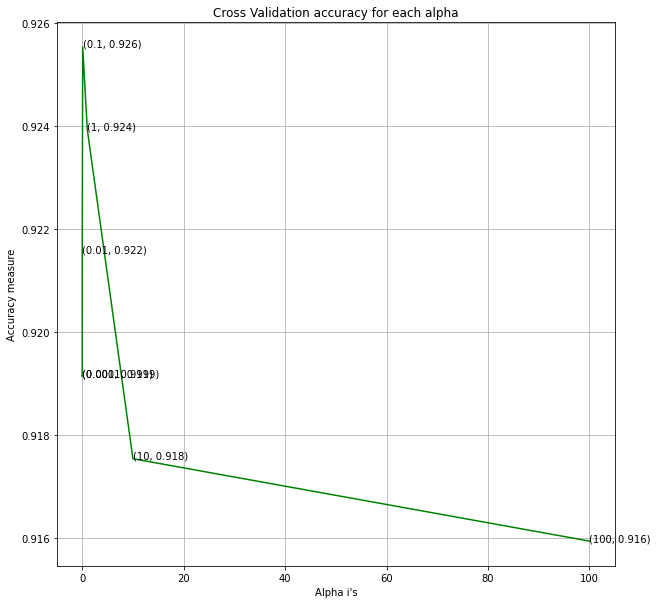

In [25]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train, y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test data for final baseline model 0.9267352185089974
Precision on test data for final baseline model 0.9356955380577427
Recall on test data for final baseline model 0.916452442159383
-------------------------------------------------- Confusion matrix --------------------------------------------------


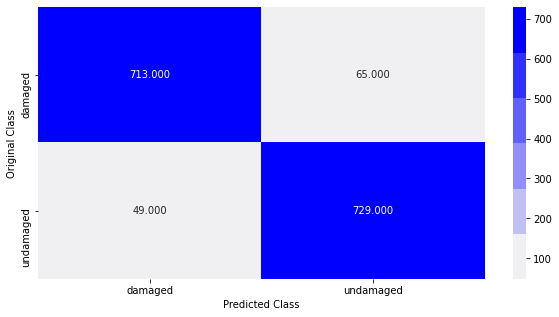

In [26]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'densenet/densenet_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y, class_labels)

In [28]:
densenet_scores = densenet_scores.append({'Model': 'Densenet baseline', 'Accuracy': '0.92675', 'Precision': '0.93569', 'Recall': '0.91645'}, ignore_index= True)

## CNN (Training FC layers only)

In [35]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_tensor = input_layer)
    densenet = non_trainable(densenet)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(densenet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

In [36]:
model = create_model(1,'sigmoid')

In [37]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=["accuracy"])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.473074 to fit



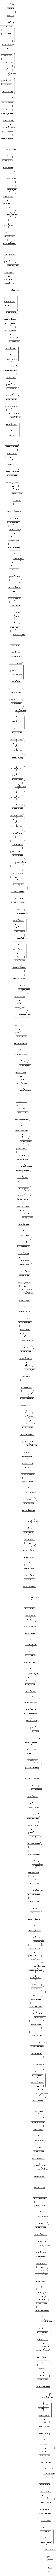

In [39]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [40]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [41]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [42]:
train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 1556/batch_size
n_steps_epoch = 6244/batch_size

Found 6244 images belonging to 2 classes.
Found 1556 images belonging to 2 classes.


In [43]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=20,callbacks=[checkpoint])

Epoch 1/20
780/780 [==============================] - 2869s 4s/step - loss: 0.7386 - accuracy: 0.7061 - val_loss: 0.4197 - val_accuracy: 0.8008

Epoch 00001: val_accuracy improved from -inf to 0.80077, saving model to densenet/densenet_fc-0.801.hdf5
Epoch 2/20
780/780 [==============================] - 54s 69ms/step - loss: 0.3988 - accuracy: 0.8193 - val_loss: 0.3044 - val_accuracy: 0.8740

Epoch 00002: val_accuracy improved from 0.80077 to 0.87404, saving model to densenet/densenet_fc-0.874.hdf5
Epoch 3/20
780/780 [==============================] - 57s 72ms/step - loss: 0.2968 - accuracy: 0.8687 - val_loss: 0.2739 - val_accuracy: 0.8811

Epoch 00003: val_accuracy improved from 0.87404 to 0.88111, saving model to densenet/densenet_fc-0.881.hdf5
Epoch 4/20
780/780 [==============================] - 56s 72ms/step - loss: 0.2254 - accuracy: 0.9106 - val_loss: 0.2315 - val_accuracy: 0.9087

Epoch 00004: val_accuracy improved from 0.88111 to 0.90874, saving model to densenet/densenet_fc-0.

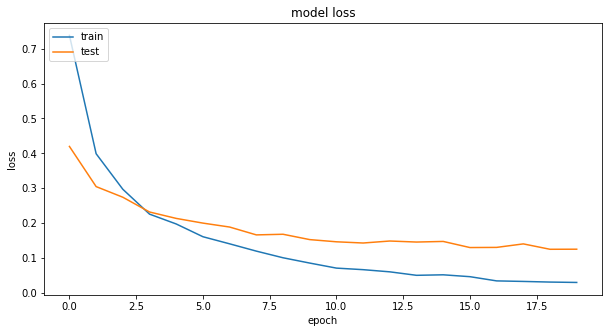

The loss for final model is  0.12948109209537506


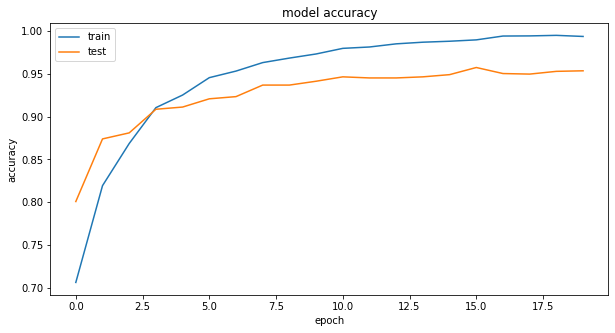

The accuracy for final model is  0.9575835466384888


In [44]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [45]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1556 images belonging to 2 classes.


In [48]:
best_model = load_model('densenet/densenet_fc-0.958.hdf5')

In [49]:
y_pred = best_model.predict(x_test)

In [50]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

In [53]:
precision, recall = compute_precision_recall(y_true, y_predicted)
print ('Precision on test data for final baseline model', precision)
print ('Recall on test data for final baseline model', recall)
binary_confusion_matrix(y_true, y_predicted, class_labels)

ValueError: ignored

In [ ]:
densenet_scores = densenet_scores.append({'Model': 'Densenet FC', 'Accuracy': '0.', 'Precision': '0.', 'Recall': '0.'},ignore_index= True)

## CNN (Training All layers)

In [54]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(densenet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

In [55]:
model = create_model(1,'sigmoid')

In [56]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=["accuracy"])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           Input_Layer[0][0]                
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.473074 to fit



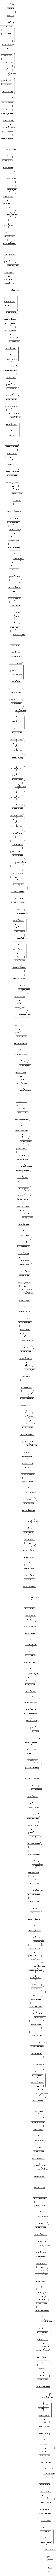

In [58]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [59]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [60]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [61]:
train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 1556/batch_size
n_steps_epoch = 6244/batch_size

Found 6244 images belonging to 2 classes.
Found 1556 images belonging to 2 classes.


In [62]:
model.fit(train_generator, validation_data = test_generator, validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=20,callbacks=[checkpoint])

Epoch 1/20
780/780 [==============================] - 140s 158ms/step - loss: 0.5483 - accuracy: 0.7322 - val_loss: 0.3301 - val_accuracy: 0.8599

Epoch 00001: val_accuracy improved from -inf to 0.85990, saving model to densenet/densenet_all-0.860.hdf5
Epoch 2/20
780/780 [==============================] - 121s 154ms/step - loss: 0.3369 - accuracy: 0.8528 - val_loss: 0.2226 - val_accuracy: 0.9177

Epoch 00002: val_accuracy improved from 0.85990 to 0.91774, saving model to densenet/densenet_all-0.918.hdf5
Epoch 3/20
780/780 [==============================] - 121s 154ms/step - loss: 0.2425 - accuracy: 0.9013 - val_loss: 0.1762 - val_accuracy: 0.9447

Epoch 00003: val_accuracy improved from 0.91774 to 0.94473, saving model to densenet/densenet_all-0.945.hdf5
Epoch 4/20
780/780 [==============================] - 121s 154ms/step - loss: 0.1935 - accuracy: 0.9247 - val_loss: 0.1312 - val_accuracy: 0.9608

Epoch 00004: val_accuracy improved from 0.94473 to 0.96080, saving model to densenet/den

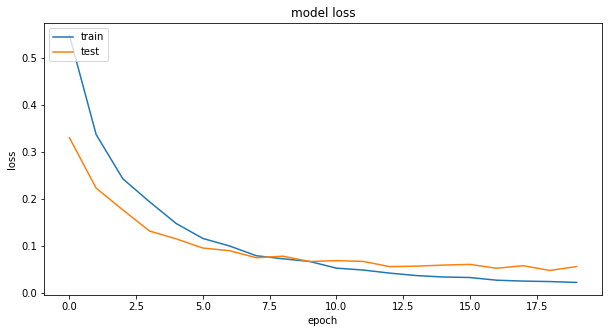

The loss for final model is  0.04701456427574158


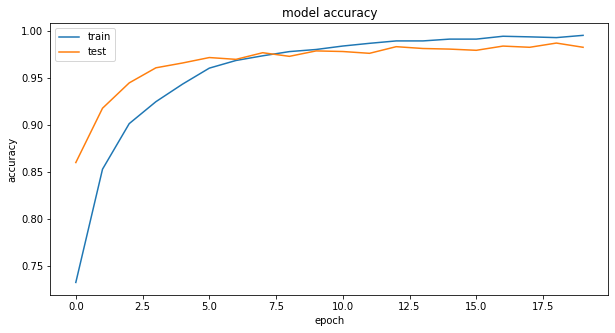

The accuracy for final model is  0.9871465563774109


In [63]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [64]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1556 images belonging to 2 classes.


In [ ]:
best_model = load_model('densenet/densenet_all-0..hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

In [65]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted, class_labels)

ValueError: ignored

In [ ]:
densenet_scores = densenet_scores.append({'Model':'Densenet all','Accuracy':'0.','Precision':'0.','Recall':'0.'},ignore_index= True)

In [ ]:
densenet_scores.to_csv('densenet_scores.csv',index=False)